#### **imports**

In [1]:
import pickle
import sys
from collections import Counter
from collections import OrderedDict
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid
from collections import OrderedDict
from collections import Counter
import shap

# Set the random seed
np.random.seed(123)
random_state = 123

# Clustering
from sklearn.cluster import KMeans

# Evaluation
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

# Add the outer directory
sys.path.append('../')
from eval_surv_copy import EvalSurv

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### **Load Data**

In [2]:
# Read the pickled DataFrames
with open('data/x_train_reshape_tv.pickle', 'rb') as file:
    x_train_reshape_tv = pickle.load(file)
with open('data/x_test_reshape_tv.pickle', 'rb') as file:
    x_test_reshape_tv = pickle.load(file)
with open('data/x_val_reshape_tv.pickle', 'rb') as file:
    x_val_reshape_tv = pickle.load(file)

# Read the pickled targets
with open('data/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)
with open('data/y_test.pickle', 'rb') as file:
    y_test = pickle.load(file)
with open('data/y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)

# Read the pickled DataFrame
with open('data/consolidated_pat_tbl_tv.pickle', 'rb') as file:
    consolidated_pat_tbl_tv = pickle.load(file)

#### **Survival Prediction**

In [3]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

    def nll_logistic_hazard(self , logits , targets , dur_idx):
        '''
        logits - parameterized inv.logit(hazards) from nn
        targets - survival matrix 
        '''
        logits = torch.Tensor(logits)
        targets = torch.Tensor(targets)
        dur_idx = torch.Tensor(dur_idx).to(torch.int64).view(-1 , 1)

        loss = F.binary_cross_entropy_with_logits(input = logits , target = targets , reduction = 'none')
        
        assert loss.shape == targets.shape , 'must match'

        # cumulative hazards
        loss = loss.cumsum(1)
        loss = loss.gather(1, dur_idx)
        
        return loss.view(-1).mean()

In [4]:
class RNN_Net(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(RNN_Net , self).__init__()

        # Define the dimensions of the RNN
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn = nn.RNN(self.input_size, self.hidden_size, batch_first=True)
        
        # Feed-forward nn
        self.fc = nn.Sequential( 
            nn.Linear(hidden_size, output_size),
            nn.Dropout(dropout_rate),
            nn.ReLU()
        )

    def forward(self, features, lengths):
        # Pack the sequences before passing to the RNN
        packed_sequences = nn.utils.rnn.pack_padded_sequence(features, lengths, batch_first=True, enforce_sorted=False)

        # Pass through the RNN
        rnn_outputs, hidden = self.rnn(packed_sequences)

        # Optionally, unpack the outputs back to the padded form
        rnn_outputs_padded, _ = nn.utils.rnn.pad_packed_sequence(rnn_outputs, batch_first=True)
        
        # Get the output from the last time step
        output = self.fc(rnn_outputs_padded[:, -1, :])

        return output, hidden

In [5]:
# Create a custom dataset with the padded sequences and original lengths
class SequenceDataset(Dataset):
    def __init__(self, features, original_lengths, durations, events):
        self.data = features
        self.original_lengths = original_lengths
        self.durations = durations
        self.events = events
        assert self.data.shape[0] == self.durations.shape[0] == self.events.shape[0] == self.original_lengths.shape[0], 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.original_lengths[idx] , self.durations[idx] , self.events[idx]


In [6]:
class Surv_Matrix:
    def __init__(self , duration_index , events , q_cuts=10):
        self.duration_index = duration_index
        self.events = events
        self.q_cuts = q_cuts
    
    def make_survival_matrix(self):
        '''
        converts durations and index into a matrix denoting time of event
        this is the y_ij matrix as shown in Kvamme's paper
        '''
        self.surv_matrix = torch.eye(self.q_cuts)[self.duration_index] 
        self.surv_matrix = self.surv_matrix*self.events.reshape(-1 , 1) # censoring mask
        return self.surv_matrix

In [7]:
class Transforms:
    def __init__(self , durations):
        self.durations = durations
        
    def discrete_transform(self , _cuts):
        '''
        cut at even spaces
        '''
        self.bin_edges = np.linspace(self.durations.min() , self.durations.max() , _cuts) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = self.duration_index.max()+1
        # print(self.n_duration_index)
        assert self.n_duration_index == _cuts , 'must match'
        return self.duration_index

In [8]:
q_cuts = 15 # number of discretized durations

# Prepare val and test data
get_target = lambda df: (df['time_to_event'].values, df['death'].values)

y_train_dur , y_train_event = get_target(y_train)

y_test_dur , y_test_event = get_target(y_test)
t_test = Transforms(durations = y_test_dur)
dur_idx_test = t_test.discrete_transform(_cuts = q_cuts)

# get duration, event
y_val_dur , y_val_event = get_target(y_val)
                
# transform to discrete
t_val = Transforms(durations = y_val_dur)
dur_idx_val = t_val.discrete_transform(_cuts = q_cuts)

In [9]:
input_size = x_train_reshape_tv[0].shape[1]

hidden_size = 32
output_size = t_test.n_duration_index

# Create a data loader for batching and shuffling
batch_size = 1024
num_epochs = 20
learning_rate = 0.01
shuffle = True
patience = 20
dropout = 0.5

# build net(s)
nets = []

# init net
net = RNN_Net(input_size , hidden_size , output_size , dropout_rate = dropout)
# init optim
optimizer = torch.optim.Adam(net.parameters() , lr = learning_rate)

In [10]:
# build surv matrix for val data
sm_val = Surv_Matrix(duration_index = dur_idx_val , events = y_val_event , q_cuts = q_cuts)
surv_mat_val = sm_val.make_survival_matrix()

In [11]:
# init loss
l = generic_Loss()

# init loss for early stopping
best_loss = np.Inf

# get features
features = x_train_reshape_tv
original_lengths = torch.tensor([len(seq) for seq in features])

# get death time and event indicator
y_train_dur , y_train_event = get_target(y_train)

t_train = Transforms(durations = y_train_dur)
dur_idx = t_train.discrete_transform(_cuts = q_cuts)
   
# Custom collate function to handle variable-length sequences
def custom_collate_fn(batch):
    # Sort the batch by sequence length (descending order)
    batch = sorted(batch, key=lambda x: x[1], reverse=True)

    # Separate sequences and lengths
    features = [item[0] for item in batch]
    lengths = [item[1] for item in batch]
    dur_idx = [item[2] for item in batch]
    events = [item[3] for item in batch]

    # Pad sequences to the same length (use padding value 0)
    padded_sequences = torch.nn.utils.rnn.pad_sequence(features, batch_first=True)

    return padded_sequences, torch.tensor(lengths) , torch.Tensor(dur_idx) , torch.Tensor(events)
 
# Create an instance of your custom dataset
dataset = SequenceDataset(features, original_lengths, dur_idx , y_train_event) # need to change outcomes[0] to indexed version
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=custom_collate_fn)

In [12]:
# Training loop
for epoch in range(num_epochs):
    for patient_image , lengths , dur_idx , eve in  dataloader:
        # Prime for training
        net.train()

        # forward pass
        phi_train , _ = net(patient_image , lengths)
        
        # make survival matrix
        dur_idx = dur_idx.to(torch.int64)
        sm = Surv_Matrix(duration_index = dur_idx, events = eve , q_cuts = q_cuts)
        surv_mat = sm.make_survival_matrix()     
        # get loss
        loss = l.nll_logistic_hazard(logits = phi_train , targets = surv_mat , dur_idx = dur_idx)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #     # Early stopping
    #     with torch.no_grad():
    #         # compute loss
    #         phi_val = net(torch.Tensor(x_val_reshape_tv_pca))
    #         val_loss = l.nll_logistic_hazard(logits = phi_val, targets = surv_mat_val , dur_idx = dur_idx_val)
        
    #     # get duration, event
    #     y_val_dur , y_val_event = get_target(y_val)
        
    #     # transform to discrete
    #     t_val = Transforms(durations = y_val_dur)
    #     dur_idx_val = t_val.discrete_transform(_cuts = q_cuts)
        
    #     # build surv matrix for val data
    #     sm_val = Surv_Matrix(duration_index = dur_idx_val , events = y_val_event , q_cuts = q_cuts)
    #     surv_mat_val = sm_val.make_survival_matrix()
        
    #     # Check if validation loss has improved
    #     if val_loss < best_loss:
    #         best_loss = val_loss
    #         counter = 0
    #     else:
    #         counter += 1
        
    #     # Check if early stopping condition is met
    #     if counter >= patience:
    #         # print(f"Early stopping at epoch {epoch}.")
    #         break
    
        print(f'''Epoch {epoch}: Training Loss: {loss.item():.4f}''') 

Epoch 0: Training Loss: 2.8994
Epoch 0: Training Loss: 2.8989
Epoch 0: Training Loss: 2.7603
Epoch 0: Training Loss: 2.7655
Epoch 1: Training Loss: 2.8137
Epoch 1: Training Loss: 2.7347
Epoch 1: Training Loss: 2.8366
Epoch 1: Training Loss: 2.8117
Epoch 2: Training Loss: 2.7687
Epoch 2: Training Loss: 2.8139
Epoch 2: Training Loss: 2.6926
Epoch 2: Training Loss: 2.7944
Epoch 3: Training Loss: 2.7250
Epoch 3: Training Loss: 2.7071
Epoch 3: Training Loss: 2.8012
Epoch 3: Training Loss: 2.7645
Epoch 4: Training Loss: 2.7358
Epoch 4: Training Loss: 2.7198
Epoch 4: Training Loss: 2.7577
Epoch 4: Training Loss: 2.7843
Epoch 5: Training Loss: 2.7821
Epoch 5: Training Loss: 2.7888
Epoch 5: Training Loss: 2.6501
Epoch 5: Training Loss: 2.7668
Epoch 6: Training Loss: 2.6832
Epoch 6: Training Loss: 2.7557
Epoch 6: Training Loss: 2.7239
Epoch 6: Training Loss: 2.8930
Epoch 7: Training Loss: 2.7462
Epoch 7: Training Loss: 2.7137
Epoch 7: Training Loss: 2.7029
Epoch 7: Training Loss: 2.8930
Epoch 8:

KeyboardInterrupt: 

**Testing**

In [ ]:
# Testing
surv = [] # length will be equal to number of cluster
mc_iter = 69

# init empty lists for duration and event 
y_test_dur = []
y_test_event = []

# get features, death time and event indicator
features = torch.Tensor(x_test_reshape_tv_pca)
    
# get death time and event indicator
y_test_dur , y_test_event = get_target(y_test)

surv = []

# apply Monte Carlo dropout
for _ in range(mc_iter):
        
    # Prime dropout layers
    net.train()
        
    # predict
    mc_haz = torch.sigmoid(net(features))
    mc_survival = torch.log(1 - mc_haz).cumsum(1).exp().detach().numpy()

    # append survivals from different runs
    surv.append(mc_survival)
    
# convert to 3d array
surv = np.array(surv)

# get stats
mean_ = np.mean(surv , axis = 0)
up_ = np.quantile(surv , axis = 0 , q = 0.95)
low_ = np.quantile(surv , axis = 0 , q = 0.05)

# QCs
assert mean_.shape[0] == up_.shape[0] == low_.shape[0] == y_test_dur.shape[0] == y_test_event.shape[0] , 'shape mismatch'

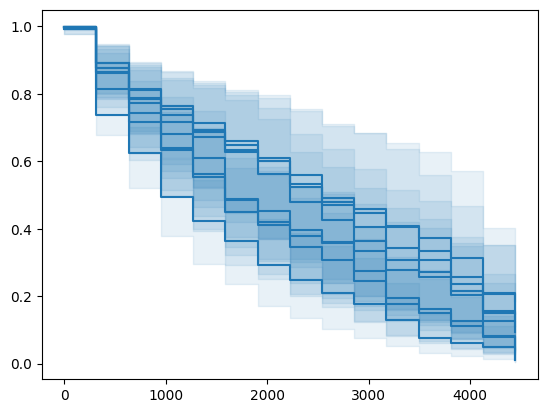

In [ ]:
def plot_with_cf(mean_ , low_ , up_ , _from , _to = None):
    if _to is not None:
        for _ , (m , l , u) in enumerate(zip(mean_[_from:_to] , low_[_from:_to] , up_[_from:_to])):
            plt.step(t_test.bin_edges , m , where = 'post' , label = 'mean' , color = 'C0');
            plt.fill_between(t_test.bin_edges , l , u , step = 'post' , alpha = 0.1 , label = 'confint' , color = 'C0');
    else:
        m , l , u = mean_[_from] , low_[_from] , up_[_from]
        plt.step(t_test.bin_edges , m , where = 'post' , label = 'mean' , color = 'C0');
        plt.fill_between(t_test.bin_edges , l , u , step = 'post' , alpha = 0.1 , label = 'confint' , color = 'C0');

plot_with_cf(mean_ , low_ , up_ , _from = 2 , _to = 10)

shapes : (1180, 1180, 1180, 1180)
concordance-td: 0.5456501463193166
integrated brier score 0.3519436753611288


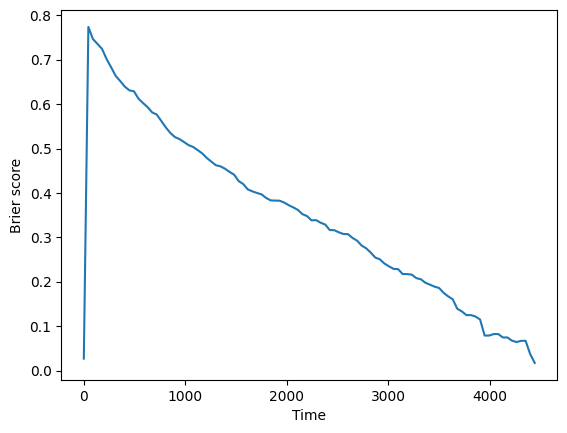

In [ ]:
# Evaluation

ev_ = EvalSurv(pd.DataFrame(mean_.T) , y_test_dur , y_test_event , censor_surv='km')
print(f'concordance-td: {ev_.concordance_td()}')

time_grid = np.linspace(y_test_dur.min(), y_test_dur.max(), 100)
ev_.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev_.integrated_brier_score(time_grid) }')

## **Explainer**

In [ ]:
# SHAP Values
grp = 1

background = x_train_grouped.get_group(grp)
background = torch.Tensor(background.iloc[: , :-2].to_numpy()) # curtail  features column

testing_data = x_test_grouped.get_group(grp)
testing_data = torch.Tensor(testing_data.iloc[: , :-2].to_numpy()) # curtail  features column

explainer = shap.DeepExplainer(nets[i][0] , background)
shap_values = explainer.shap_values(testing_data)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


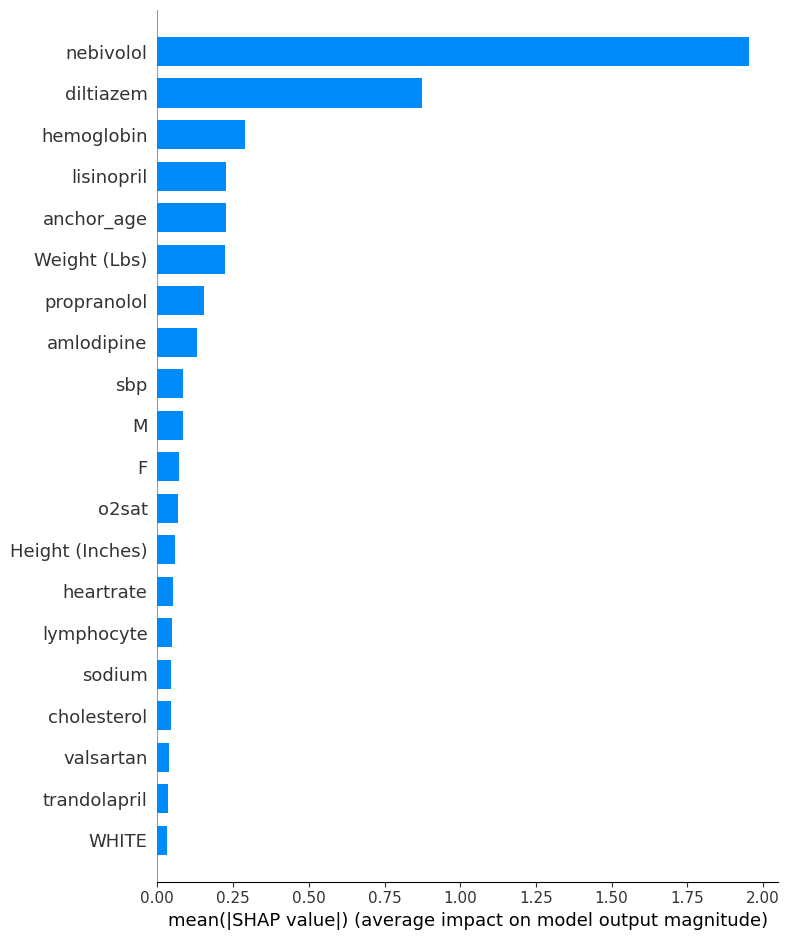

In [ ]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

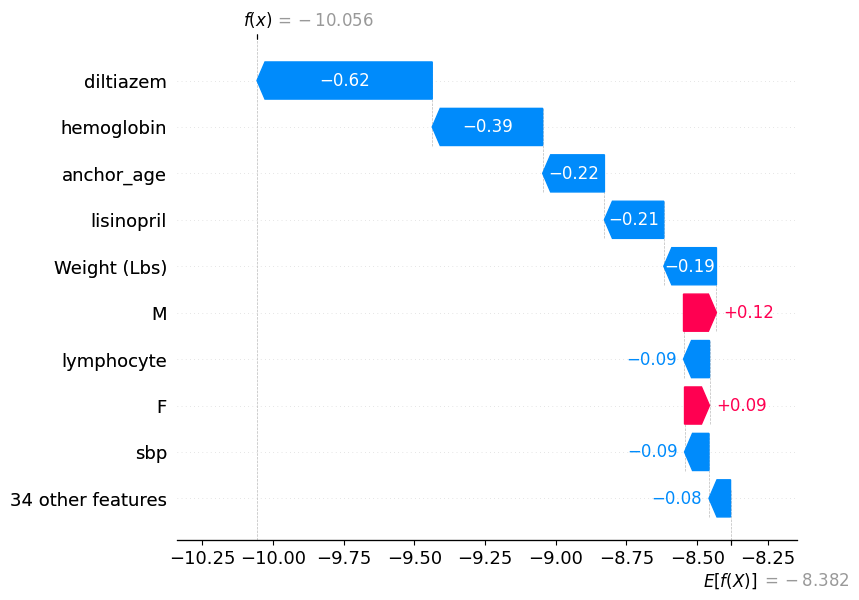

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], 
                                       feature_names = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

-----------------

## **JUNK**

In [ ]:
# # Define the RNN Autoencoder model
# class RNN_AE(nn.Module):
#     def __init__(self, input_size, hidden_size, bottleneck_size):
#         super(RNN_AE, self).__init__()
#         self.hidden_size = hidden_size
        
#         # RNN Encoder
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
#         # Bottleneck layer
#         self.encoder = nn.Linear(hidden_size, bottleneck_size)
        
#         # Autoencoder Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(bottleneck_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, input_size)
#         )

#     def forward(self, x):
#         # RNN Encoder
#         rnn_output, _ = self.rnn(x)
        
#         # Bottleneck Layer
#         encoded_output = self.encoder(rnn_output)
        
#         # Autoencoder Decoder
#         decoded_output = self.decoder(encoded_output)
        
#         return encoded_output , decoded_output

In [ ]:
# input_size = 91
# hidden_size = 100
# bottleneck_size = 46

# # Model Initialization
# model = RNN_AE(input_size, hidden_size, bottleneck_size)
 
# # Validation using MSE Loss function
# loss_function = torch.nn.MSELoss()
 
# # Using an Adam Optimizer with lr = 0.1
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr = 1e-1,
#                              weight_decay = 1e-8)

In [ ]:
# enc , dec = model(torch.Tensor(x_train_reshape_tv[1000]))
# enc.shape , dec.shape

(torch.Size([122, 46]), torch.Size([122, 91]))

In [ ]:
# # # %%time

# # # # def get_spca(L , M , k):
# # # #     # normalize
# # # #     L_ = L/np.linalg.norm(L , axis = 0)
# # # #     M_ = M/np.linalg.norm(M , axis = 0)
# # # #     # get spca
# # # #     s_pca = np.trace(L_@M_.T@M_@L_.T)/k
# # # #     return s_pca

# # # # pca_transforms = []
# # # # n_components = 1

# # # # for idx , x in enumerate(x_train_reshape_tv):
# # # #     pca = PCA(n_components = n_components , svd_solver = 'arpack') # encourage sparse solutions
# # # #     pca_transform_x = pca.fit_transform(x)
# # # #     # store in list
# # # #     pca_transforms.append(pca_transform_x)
# # # # # form an array (optional)
# # # # pca_transforms_arr = np.array(pca_transforms , dtype = 'object')

# # # # assert len(pca_transforms_arr) == len(x_train_reshape_tv) , 'lengths must match'

# # # # # Create a square distance matrix
# # # # distance_matrix = np.zeros((len(pca_transforms_arr) , len(pca_transforms_arr)))

# # # # for i in range(len(pca_transforms_arr)):
# # # #     for j in range(i , len(pca_transforms_arr)):
# # # #         distance_matrix[i,j] = get_spca(L = pca_transforms_arr[i] , M = pca_transforms_arr[j] , k = n_components)
# # # #         distance_matrix[j,i] = distance_matrix[i,j]

# # # # L = np.random.randn(3,3)
# # # # M = np.random.randn(40,3)
# # # # get_spca(L , M , 5)
# # # pca.components_

# # import pickle
# # # Pickle the DataFrame
# # with open('data/distance_matrix_train_.pickle', 'wb') as file:
# #     pickle.dump(distance_matrix, file)
# # Read the pickled DataFrames
# with open('data/distance_matrix_train_.pickle', 'rb') as file:
#     distance_matrix_train_ = pickle.load(file)

In [ ]:
# def do_pca(arr_nd , num_principal_components = 5):
#     # container
#     reduced_data = []

#     # iterate through nd array
#     for i in range(arr_nd.shape[0]):
#         curr_mtx = arr_nd[i]
#         # Create a PCA object and fit_transform the data
#         pca = PCA(n_components=num_principal_components, svd_solver = 'full')
#         # get reduced matrix
#         reduced_matrix = pca.fit_transform(curr_mtx)
#         # add to container
#         reduced_data.append(reduced_matrix)

#     return np.array(reduced_data, dtype = 'float32')
# num_principal_components = 10
# x_train_reshape_tv_pca = do_pca(x_train_reshape_tv , num_principal_components)
# x_test_reshape_tv_pca = do_pca(x_test_reshape_tv , num_principal_components)
# x_val_reshape_tv_pca = do_pca(x_val_reshape_tv , num_principal_components)